## Installing and import packages

In [ ]:
#!pip install googletrans==3.1.0a0

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16351 sha256=eafffbe4a6a2f8ab0b9fe13ec626fc7230af39d29c1b216d80b543dda705ce6b
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling ch

In [ ]:
!pip install transformers datasets eli5

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import eli5

import re, string
from collections import defaultdict, Counter
from itertools import chain

import torch
from torch.utils.data import Dataset, DataLoader

import pyarrow as pa
from datasets import Dataset

import transformers as ppb # pytorch transformers
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup,
    DataCollatorWithPadding,
    pipeline,
    Trainer,
    TrainingArguments)

from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import seaborn as sn

from google.colab import drive
from google.colab import output

from googletrans import Translator
translator = Translator()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Dataset of english sarcasm -- translation

In [ ]:
df_en = pd.read_csv('/content/drive/MyDrive/datasets/Sarcastic_сomments/train.csv')

In [ ]:
df_en.head()

,rate,text
0,4,Очень понравилось. Были в начале марта с соба...
1,5,В целом магазин устраивает.\nАссортимент позво...
2,5,"Очень хорошо что открылась 5 ка, теперь не над..."
3,3,Пятёрочка громко объявила о том как она заботи...
4,3,"Тесно, вечная сутолока, между рядами трудно ра..."


In [ ]:
df_ru = pd.DataFrame(columns=['comment', 'label'])

In [ ]:
for index, row in df_en.iterrows():
    df_ru.loc[index + 1] = [translator.translate(row['text'], dest='ru').text] + [row['Y']]
    if not(index % 100):
      print(f"{index} is translated")

NameError: ignored

In [ ]:
df_ru.head()

,comment,label
1,Тридцатилетние ученые представили часы конца с...,1
2,представитель Демократической партии полностью...,0
3,Ешьте овощи 9 восхитительно разных рецептов,0
4,ненастная погода мешает лжецу добраться до работы,1
5,мать довольно близко подходит к правильному ис...,1


Все переведено и сохранено (НЕ НАЖИМАТЬ!! пересчитывать достаточно долго)

In [ ]:
df_ru.to_csv('/content/drive/MyDrive/Sarcastic_сomments/train_ru.csv', index=False)

Для последующих запусков (считываем датафрейм)

In [ ]:
df_ru = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_ru.csv')

## Dataset of Russian jokes -- read_csv

In [ ]:
df_jokes = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/jokes.csv')
df_jokes = df_jokes.drop(columns=['theme', 'rating'])
df_jokes = df_jokes.rename(columns={"text": "comment"})
df_jokes['label'] = 1

In [ ]:
df_jokes.head()

,comment,label
0,На суде в Стамбуле обвиняемый сказал:\r\n- На...,1
1,"- Вы продолжаете утверждать, что обвиняемый н...",1
2,"На суде.\r\n- Итак, когда дело дошло до столкн...",1
3,Старую леди сбил автомобиль. На суде ее спраши...,1
4,"Судья говорит:\r\n- Согласно вашей жалобе, об...",1


In [ ]:
df_jokes.to_csv('/content/drive/MyDrive/Sarcastic_сomments/train_ru_jokes.csv', index=False)

## Make the final dataset

In [ ]:
df_ru_jokes = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_ru_jokes.csv')
df_en_sarcasm_or_not = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_ru.csv')

df_en_non_sarcasm = df_en_sarcasm_or_not.query('label==0')
df_en_sarcasm = df_en_sarcasm_or_not.query('label==1')

print("Translated non-sarcasm: ", len(df_en_non_sarcasm))
print("Translated sarcasm: ", len(df_en_sarcasm))
print("Russian jokes: ", len(df_ru_jokes))

Translated non-sarcasm:  10479
Translated sarcasm:  9554
Russian jokes:  130204


In [ ]:
# # big dataset without jokes
# non_sarcasm_num = 9500
# sarcasm_num = 9500
# jokes_num = 0

# big dataset with jokes
non_sarcasm_num = 10000
sarcasm_num = 5000
jokes_num = 5000

df_non_sarcasm = df_en_non_sarcasm.sample(frac=1).iloc[0:non_sarcasm_num, :]
df_sarcasm = df_en_sarcasm.sample(frac=1).iloc[0:sarcasm_num, :]
df_jokes = df_ru_jokes.sample(frac=1).iloc[0:jokes_num, :]

df = pd.concat([df_non_sarcasm, df_sarcasm, df_jokes]).sample(frac=1).reset_index(drop=True)

# delete punctuation
df = df.replace(to_replace=r'\r', value='', regex=True)
df = df.replace(to_replace=r'\n', value='', regex=True)
df.comment = df.comment.str.replace('[^\w\s]','')

<ipython-input-5-3b7fce9bd753>:20: FutureWarning: The default value of regex will change from True to False in a future version.
  df.comment = df.comment.str.replace('[^\w\s]','')


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


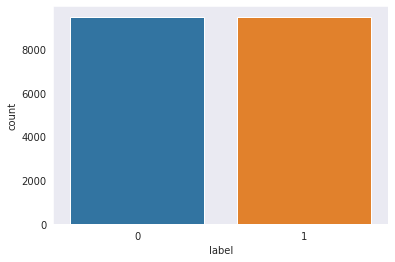

In [ ]:
sns.set_style("dark")
sns.countplot(df.label)

In [ ]:
df.head()

,comment,label
0,фиксин добавлен в пищевую пирамиду,1
1,этот ублюдок кушнер,0
2,второклассник любит оставлять фиолетовые табле...,1
3,Саддам в клетке станет изюминкой инаугурационн...,1
4,NBC инсценирует убийства братьев Менендес в сп...,0


In [ ]:
## proportion train-test
n_train = 0.7
n_test = 0.3

ind = round(len(df)*n_train)
df_train = df.iloc[0:ind, :]
# df_test = df.iloc[ind:, :]
print(len(df_train))
# print(len(df_test))

13300


In [ ]:
# df_train.to_csv('/content/drive/MyDrive/Sarcastic_сomments/train_final_no_jokes.csv', index=False)

df_train.to_csv('/content/drive/MyDrive/Sarcastic_сomments/train_final.csv', index=False)
df_test.to_csv('/content/drive/MyDrive/Sarcastic_сomments/test_final.csv', index=False)

## LogReg (baseline score)

### Data preprocessing

Remove links (just in case)

In [ ]:
def remove_links(text):
    return re.sub(r'http\S+', '', text)

Remove the text in brackets

In [ ]:
def remove_between_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

Preprosess data

In [ ]:
def preprosess_data(dataframe):
    dataframe['comment'] = dataframe['comment'].apply(remove_links)
    dataframe['comment'] = dataframe['comment'].apply(remove_between_brackets)
    return dataframe

# df_train = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_final.csv')
df_train = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_final_no_jokes.csv')

df_test = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/test_final.csv')

df_train_preprosessed = preprosess_data(df_train)
df_test_preprosessed = preprosess_data(df_test)

In [ ]:
df_train_preprosessed.head()

,comment,label
0,фиксин добавлен в пищевую пирамиду,1
1,этот ублюдок кушнер,0
2,второклассник любит оставлять фиолетовые табле...,1
3,Саддам в клетке станет изюминкой инаугурационн...,1
4,NBC инсценирует убийства братьев Менендес в сп...,0


Import data

In [ ]:
X_train = df_train_preprosessed.comment
Y_train = df_train_preprosessed.label
X_test = df_test_preprosessed.comment
Y_test = df_test_preprosessed.label

Make a set of russian stop words including punctuation signs and digits

In [ ]:
nltk.download("stopwords")
ru_stopwords = set(stopwords.words('russian'))
punctuation = list(string.punctuation) + [str(i) for i in range(10)] + ['']
ru_stopwords.update(punctuation)

print(ru_stopwords)

{'', '7', 'два', '>', 'вы', 'свою', 'как', 'между', '/', '+', 'за', 'ж', ',', 'по', 'раз', '}', 'один', 'чуть', 'этого', 'при', 'тоже', 'больше', 'тем', 'на', 'почти', 'же', 'себе', '|', 'этой', 'сам', 'есть', 'моя', 'зачем', 'через', 'чего', 'тот', 'никогда', '`', 'ни', 'потому', 'от', 'без', 'нибудь', '"', 'или', 'сейчас', 'их', 'было', ']', 'мой', 'о', 'уж', 'ну', 'уже', 'куда', 'опять', 'лучше', 'всю', 'во', 'только', '^', '9', 'три', 'не', 'всех', 'нет', 'ее', 'хоть', 'чтобы', '<', 'нас', 'что', 'вам', ';', '4', 'меня', 'тебя', 'наконец', 'себя', 'иногда', 'после', 'тут', 'какая', "'", '?', 'перед', 'когда', 'него', 'кто', 'можно', 'но', 'про', 'мы', 'будто', 'вот', '*', '@', 'там', '8', 'будет', 'них', 'нельзя', 'совсем', 'они', 'быть', 'чтоб', '(', 'нее', 'в', 'из', 'так', '2', 'где', '&', 'тогда', 'все', '-', 'даже', 'ведь', 'она', 'том', 'конечно', 'чем', 'надо', 'над', 'со', '6', 'хорошо', 'к', 'его', 'у', 'этом', 'такой', '_', '#', 'ней', 'эту', 'ты', '%', '.', 'мне', 'об', 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Tf-Idf vectorizer

In [ ]:
counter_tfidf = TfidfVectorizer(stop_words=ru_stopwords, ngram_range=(1,1), lowercase=True)

count_train = counter_tfidf.fit_transform(X_train)
count_test = counter_tfidf.transform(X_test)

In [ ]:
print(count_train[0]) # the tf-idf is between [0,1]

  (0, 20834)	0.4982673423721462
  (0, 20919)	0.4982673423721462
  (0, 8144)	0.4830132343537585
  (0, 32802)	0.5197668001035831


### LogReg model

In [ ]:
model_lr = LogisticRegression(random_state = 12345, max_iter = 10000, n_jobs = -1) # -1 means using all processors (CPU cores)

model_lr.fit(count_train, Y_train)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=12345)

In [ ]:
eli5.show_weights(estimator=model_lr, feature_names=counter_tfidf.get_feature_names(), top=(10, 10))

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+4.235,мужчина
+3.953,нация
+3.585,сообщить
+3.186,местный
+3.183,человек
+3.174,сообщают
+3.041,женщина
+2.908,представляет
+2.645,явно
+2.606,исследование


Predictions

Precision:  0.7988333333333333
Recall:  0.7988333333333333
F1_score:  0.7988333333333333


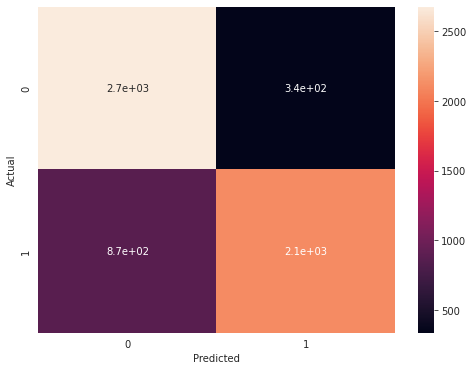

In [ ]:
def test_data_analysis(Y_pred, Y_test):
    precision = accuracy_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred, average='micro')
    F1_score = f1_score(Y_test, Y_pred, average='micro')
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1_score: ", F1_score)
    data = {'y_Actual': Y_test, 'y_Predicted': Y_pred}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize = (8, 6))
    sn.heatmap(confusion_matrix, annot=True)

Y_pred = model_lr.predict(count_test)
test_data_analysis(Y_pred, Y_test)

## Transformers (good score)

### Customized Dataset class

Метод len возвращает длину нашего набора данных. Метод getitem возвращает словарь, который состоит из самого исходного текста, списка токенов, маски внимания и метки класса. При кодировании мы указываем токенизатору, что исходный текст должен быть обрамлен служебными токенами add_special_tokens=True, а также дополняем полученные векторы до максимальной длины padding='max_len'.

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx][:self.max_len])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

NameError: ignored

### BERT Classifier model

Загрузка русскоязычной ЛУЧШЕЙ модели из репозитория hugging face rupert-tiny. https://huggingface.co/cointegrated/rubert-tiny

Для классификации необходимо добавить полностью подключенный уровень, количество входов которого является внутренним размером встраивания сети, а выход - количеством классов для классификации. В нашем случае мы классифицируем на 2 класса, и внутреннее измерение можно получить, выполнив следующую команду:

In [ ]:
class BertClassifier:

    def __init__(
        self,
        model_path,
        tokenizer_path,
        n_classes=2,
        epochs=1,
        batch_size=2,
        model_save_path='/content/bert.pt'
        ):
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model_save_path=model_save_path
        self.max_len = 512
        self.batch_size = batch_size
        self.epochs = epochs
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        self.model.to(self.device)

    def preparation(self, X_train, y_train, X_valid, y_valid):
        # create datasets
        self.train_set = CustomDataset(X_train, y_train, self.tokenizer, self.max_len)
        self.valid_set = CustomDataset(X_valid, y_valid, self.tokenizer, self.max_len)

        # create data loaders
        self.train_loader = DataLoader(self.train_set, self.batch_size, shuffle=True)
        self.valid_loader = DataLoader(self.valid_set, self.batch_size, shuffle=True)

        # helpers initialization
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=2e-5)
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=0,
                num_training_steps=len(self.train_loader) * self.epochs
                )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)

    def fit(self):
        self.model.train()
        losses = []
        correct_predictions = 0
        loader = tqdm(self.train_loader)
        for data in loader:
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss

    def valid(self):
        self.model.eval()
        losses = []
        correct_predictions = 0

        with torch.no_grad():
            loader = tqdm(self.valid_loader)
            for data in loader:
                input_ids = data["input_ids"].to(self.device)
                attention_mask = data["attention_mask"].to(self.device)
                targets = data["targets"].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                    )

                preds = torch.argmax(outputs.logits, dim=1)
                loss = self.loss_fn(outputs.logits, targets)
                correct_predictions += torch.sum(preds == targets)
                losses.append(loss.item())

        val_acc = correct_predictions.double() / len(self.valid_set)
        val_loss = np.mean(losses)
        return val_acc, val_loss

    def train(self):
        best_accuracy = 0
        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss = self.valid()
            print(f'Val loss {val_loss} accuracy {val_acc}')
            print('-' * 10)

            if val_acc > best_accuracy:
                torch.save(self.model, self.model_save_path)
                best_accuracy = val_acc

        # self.model = torch.load(self.model_save_path)

    def predict(self, text):
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }

        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)

        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )

        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

    def test_data_analysis(self, X_test, Y_test):
        pred = [self.predict(comment) for comment in X_test]
        precision = accuracy_score(Y_test, pred)
        recall = recall_score(Y_test, pred, average='micro')
        F1_score = f1_score(Y_test, pred, average='micro')
        print("Precision: ", precision)
        print("Recall: ", recall)
        print("F1_score: ", F1_score)
        data = {'y_Actual': Y_test, 'y_Predicted': pred}
        df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
        confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
        plt.figure(figsize = (8, 6))
        sn.heatmap(confusion_matrix, annot=True)



### Set, train, test

Set params

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
classifier = BertClassifier(
        model_path='cointegrated/rubert-tiny2',
        tokenizer_path='cointegrated/rubert-tiny2',
        n_classes=2,
        epochs=10,
        batch_size=64,
        model_save_path='/content/drive/MyDrive/Sarcastic_сomments/bert.pt'
)

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_final.csv')
# df_train = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_final_no_jokes.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/test_final.csv')

X = df_train.comment
Y = df_train.label

train_texts, val_texts, train_labels, val_labels = train_test_split(X, Y, test_size=0.15)

classifier.preparation(
        X_train=list(train_texts),
        y_train=list(train_labels),
        X_valid=list(val_texts),
        y_valid=list(val_labels)
    )

Train our model

In [ ]:
classifier.train()

Predict zero comment

In [ ]:
# normal sentence
print(classifier.predict("Позвони мне завтра вечером"))

In [ ]:
# joke
print(classifier.predict("В дверь никто не постучал. «Пустое множество» — подумал Штирлиц"))

In [ ]:
# sarcasm
print(classifier.predict("Продолжайте говорить. Я всегда зеваю, когда мне интересно"))

Test our model

In [ ]:
X_test = df_test.comment
Y_test = df_test.label

classifier.test_data_analysis(X_test, Y_test)

## RNN (not so good score)

In [ ]:
mvs_const = 30000

### Tokenization/Vocab/Embedding

Tokenization

In [ ]:
class Tokenizer:
    def __init__(self, word_pattern="[\w']+"):
        self.word_pattern = re.compile(word_pattern)

    def tokenize(self, text):
        return self.word_pattern.findall(text)

In [ ]:
tok = Tokenizer()
def tokenize_func(text):
    return [word for word in tok.tokenize(text)]

Preprocess the data

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_final.csv')
# df_train = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/train_final_no_jokes.csv')
df_train_preprosessed = df_train
df_train_preprosessed['comment'] = df_train_preprosessed['comment'].apply(tokenize_func)

In [ ]:
class Vocab:
    def __init__(self, tokenized_texts, max_vocab_size=None):
        """
        Builds a vocabulary by concatenating all tokenized texts and counting words.
        Most common words are placed in vocabulary, others are replaced with [UNK] token
        :param tokenized_texts: texts to build a vocab
        :param max_vocab_size: amount of words in vocabulary
        """
        counts = Counter(chain(*tokenized_texts))
        max_vocab_size = max_vocab_size or len(counts)
        common_pairs = counts.most_common(max_vocab_size)
        self.PAD_IDX = 0
        self.UNK_IDX = 1
        self.EOS_IDX = 2
        self.itos = [pair[0] for pair in common_pairs]
        self.stoi = {token: i for i, token in enumerate(self.itos)}

    def vectorize(self, text):
        """
        Maps each token to it's index in the vocabulary
        :param text: sequence of tokens
        :return: vectorized sequence
        """
        return [self.stoi.get(tok, self.UNK_IDX) for tok in text]

    def __iter__(self):
        return iter(self.itos)

    def __len__(self):
        return len(self.itos)

Функция создания встраиваемой матрицы

In [ ]:
def prepare_emb_matrix(gensim_model, vocab: Vocab):

    mean = gensim_model.vectors.mean(1).mean()
    std = gensim_model.vectors.std(1).mean()
    vec_size = gensim_model.vector_size
    emb_matrix = torch.zeros((len(vocab), vec_size))
    for i, word in enumerate(vocab.itos[1:], 1):
        try:
            emb_matrix[i] = torch.tensor(gensim_model.get_vector(word))
        except KeyError:
            emb_matrix[i] = torch.randn(vec_size) * std + mean
    return emb_matrix

In [ ]:
vocab = Vocab(df_train_preprosessed['comment'].to_list(), max_vocab_size=mvs_const)

In [ ]:
!pip install navec
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2022-12-18 11:48:45--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’

navec_hudlit_v1_12B 100%[===================>]  50.56M  46.0MB/s    in 1.1s    

2022-12-18 11:48:46 (46.0 MB/s) - ‘navec_hudlit_v1_12B_500K_300d_100q.tar.1’ saved [53012480/53012480]



In [ ]:
from navec import Navec

path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'
navec = Navec.load(path)
glove_model = navec.as_gensim

Создание матрицы встраивания (есть гораздо более крупные и качественные модели, это тест)

In [ ]:
emb_matrix = prepare_emb_matrix(glove_model, vocab)

### Class RecurrentClassifier

In [ ]:
class RecurrentClassifier(torch.nn.Module):
    def __init__(self, vocab, emb_matrix):
        super().__init__()
        self.vocab = vocab
        self.emb_matrix = emb_matrix
        self.embeddings = torch.nn.Embedding.from_pretrained(emb_matrix, freeze=True,
                                                             padding_idx=vocab.PAD_IDX)

        self.cell = torch.nn.GRU(input_size=emb_matrix.size(1),
                                 batch_first=True,
                                 hidden_size=100,
                                 num_layers=3,
                                 dropout=0.1,
                                 bidirectional=True,
                                 )

        self.out_activation = torch.nn.Sigmoid()
        self.out_dropout = torch.nn.Dropout(0.1)
        cur_out_size = 600
        out_layers = []
        for cur_hidden_size in [40]:
            out_layers.append(torch.nn.Linear(cur_out_size, cur_hidden_size))
            cur_out_size = cur_hidden_size
        out_layers.append(torch.nn.Linear(cur_out_size, 2))
        # out_layers.append(self.out_dropout)
        out_layers.append(self.out_activation)
        self.out_proj = torch.nn.Sequential(*out_layers)

    def forward(self, input):
        embedded = self.embeddings(input.data)
        states, last_state = self.cell(torch.nn.utils.rnn.PackedSequence(embedded,
                                                                         input.batch_sizes,
                                                                         sorted_indices=input.sorted_indices,
                                                                         unsorted_indices=input.unsorted_indices))

        if isinstance(last_state, tuple):
            last_state = last_state[0]
        last_state = last_state.transpose(0, 1)
        last_state = last_state.reshape(last_state.size(0), -1)
        return self.out_proj(last_state)

### Class Trainer

In [ ]:
class Trainer:
    def __init__(self, config):

        self.config = config
        self.n_epochs = config["n_epochs"]
        self.setup_opt_fn = lambda model: torch.optim.Adam(model.parameters(),
                                                           config["lr"],
                                                           weight_decay=config["weight_decay"])
        # self.setup_sheduler = lambda model: torch.optim.lr_scheduler.StepLR(self.setup_opt_fn(model),
        #                                                                     step_size=14, gamma=0.4)
        self.model = None
        self.opt = None
        self.sheduler = None
        self.history = None
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.device = config["device"]
        self.verbose = config.get("verbose", True)

    def fit(self, model, train_loader, val_loader):

        self.model = model.to(self.device)
        self.opt = self.setup_opt_fn(self.model)
        # self.sheduler = self.setup_sheduler(self.model)
        self.history = {"train_loss": [], "val_loss": [], "val_acc": []}
        for epoch in range(self.n_epochs):
            print(f"epoch: {epoch+1}")
            train_info = self._train_epoch(train_loader)
            val_info = self._val_epoch(val_loader)
            self.history["train_loss"].extend(train_info["train_loss"])
            self.history["val_loss"].append(val_info["loss"])
            self.history["val_acc"].append(val_info["acc"])
            # self.save(f"/content/drive/MyDrive/NLP_HW2_data/gensim_model_{epoch+1}.ckpt")
            # if epoch != 0:
            #    self.sheduler.step()
        return self.model.eval()

    def _train_epoch(self, train_loader):
        self.model.train()
        losses = []
        if self.verbose:
            train_loader = tqdm(train_loader)
        for batch in train_loader:
            self.model.zero_grad()
            texts, labels = batch
            logits = self.model.forward(texts.to(self.device))
            loss = self.loss_fn(logits, labels.to(self.device))
            loss.backward()
            self.opt.step()
            loss_val = loss.item()
            losses.append(loss_val)
        if self.verbose:
            train_loader.set_description(f"Loss={np.mean(losses):.3}")
            print(f"Loss={np.mean(losses):.3}")
        return {"train_loss": losses}

    def _val_epoch(self, val_loader):
        self.model.eval()
        all_logits = []
        all_labels = []
        if self.verbose:
            val_loader = tqdm(val_loader)
        with torch.no_grad():
            for batch in val_loader:
                texts, labels = batch
                logits = self.model.forward(texts.to(self.device))
                all_logits.append(logits)
                all_labels.append(labels)
        all_labels = torch.cat(all_labels).to(self.device)
        all_logits = torch.cat(all_logits)
        loss = self.loss_fn(all_logits, all_labels).item()
        acc = (all_logits.argmax(1) == all_labels).float().mean().item()
        if self.verbose:
            val_loader.set_description(f"Loss={loss:.3}; Acc:{acc:.3}")
            print(f"Loss={loss:.3}; Acc:{acc:.3}")
        return {"acc": acc, "loss": loss}

    def predict(self, test_loader):
        if self.model is None:
            raise RuntimeError("You should train the model first")
        self.model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_loader:
                texts, labels = batch
                logits = self.model.forward(texts.to(self.device))
                predictions.extend(logits.argmax(1).tolist())
        return np.asarray(predictions)

### Class TextDataset

pandas to dataset (save time)

In [ ]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_texts, labels, vocab: Vocab):
        self.texts = tokenized_texts
        self.labels = labels
        self.vocab = vocab

    def __getitem__(self, item):
        return self.vocab.vectorize(self.texts[item]) + [self.vocab.EOS_IDX], self.labels[item]

    def __len__(self):
        return len(self.texts)

    def collate_fn(self, batch):
        """
        Technical method to form a batch to feed into recurrent network
        """
        return torch.nn.utils.rnn.pack_sequence([torch.tensor(pair[0]) for pair in batch],
                                                enforce_sorted=False), torch.tensor([pair[1] for pair in batch])

### Set, train, test

Creating dataloaders

In [ ]:
X = df_train_preprosessed.comment
Y = df_train_preprosessed.label

train_texts, val_texts, train_labels, val_labels = train_test_split(X, Y, test_size=0.2)
train_dataset = TextDataset(train_texts.to_list(), train_labels.to_list(), vocab)
val_dataset = TextDataset(val_texts.to_list(), val_labels.to_list(), vocab)

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=64,
                                               shuffle=True,
                                               collate_fn=train_dataset.collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=64,
                                             shuffle=False,
                                             collate_fn=val_dataset.collate_fn)

Params

In [ ]:
trainer_config = {
    "lr": 1e-3,
    "n_epochs": 10,
    "weight_decay": 1e-6,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

In [ ]:
# torch.seed()
clf_model = RecurrentClassifier(vocab, emb_matrix)

t = Trainer(trainer_config)
t.fit(clf_model, train_dataloader, val_dataloader)

epoch: 1


  0%|          | 0/167 [00:00<?, ?it/s]

Loss=0.607


  0%|          | 0/42 [00:00<?, ?it/s]

Loss=0.56; Acc:0.736
epoch: 2


  0%|          | 0/167 [00:00<?, ?it/s]

Loss=0.546


  0%|          | 0/42 [00:00<?, ?it/s]

Loss=0.554; Acc:0.742
epoch: 3


  0%|          | 0/167 [00:00<?, ?it/s]

Loss=0.518


  0%|          | 0/42 [00:00<?, ?it/s]

Loss=0.543; Acc:0.757
epoch: 4


  0%|          | 0/167 [00:00<?, ?it/s]

Loss=0.486


  0%|          | 0/42 [00:00<?, ?it/s]

Loss=0.558; Acc:0.743
epoch: 5


  0%|          | 0/167 [00:00<?, ?it/s]

Loss=0.465


  0%|          | 0/42 [00:00<?, ?it/s]

Loss=0.543; Acc:0.761
epoch: 6


  0%|          | 0/167 [00:00<?, ?it/s]

Loss=0.443


  0%|          | 0/42 [00:00<?, ?it/s]

Loss=0.55; Acc:0.754
epoch: 7


  0%|          | 0/167 [00:00<?, ?it/s]

Loss=0.435


  0%|          | 0/42 [00:00<?, ?it/s]

Loss=0.544; Acc:0.76
epoch: 8


  0%|          | 0/167 [00:00<?, ?it/s]

Loss=0.427


  0%|          | 0/42 [00:00<?, ?it/s]

Loss=0.547; Acc:0.758
epoch: 9


  0%|          | 0/167 [00:00<?, ?it/s]

Loss=0.415


  0%|          | 0/42 [00:00<?, ?it/s]

Loss=0.545; Acc:0.758
epoch: 10


  0%|          | 0/167 [00:00<?, ?it/s]

Loss=0.407


  0%|          | 0/42 [00:00<?, ?it/s]

Loss=0.545; Acc:0.761


RecurrentClassifier(
  (embeddings): Embedding(30000, 300, padding_idx=0)
  (cell): GRU(300, 100, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (out_activation): Sigmoid()
  (out_dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Sequential(
    (0): Linear(in_features=600, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=2, bias=True)
    (2): Sigmoid()
  )
)

In [ ]:
def predict(model, comment):
    tok_text = tok.tokenize(comment)
    indexed_text = torch.tensor(vocab.vectorize(tok_text)).to(t.device)
    label = model(torch.nn.utils.rnn.pack_sequence([indexed_text])).argmax().item()
    return label

Precision:  0.8018333333333333
Recall:  0.8018333333333333
F1_score:  0.8018333333333333


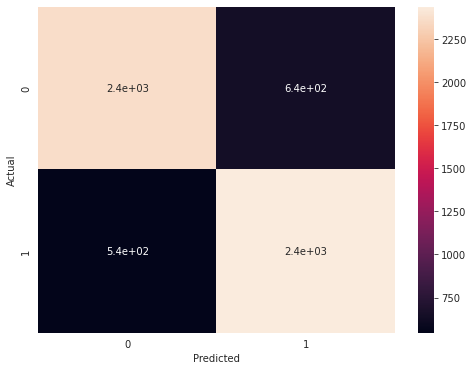

In [ ]:
def test_data_analysis(X_test, Y_test):
    Y_pred = [predict(t.model, comment) for comment in X_test]
    precision = accuracy_score(Y_test, Y_pred)
    recall = recall_score(Y_test, Y_pred, average='micro')
    F1_score = f1_score(Y_test, Y_pred, average='micro')
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F1_score: ", F1_score)
    data = {'y_Actual': Y_test, 'y_Predicted': Y_pred}
    df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
    confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
    plt.figure(figsize = (8, 6))
    sn.heatmap(confusion_matrix, annot=True)

df_test = pd.read_csv('/content/drive/MyDrive/Sarcastic_сomments/test_final.csv')
X_test = df_test.comment
Y_test = df_test.label

test_data_analysis(X_test, Y_test)